In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tau_cal
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm

In [2]:
path = 'synapses_Alex_method_1/'
ab_path = path + 'all_binned/'
al_path = path + 'all_linear/'

In [3]:
Tarr = np.load(path + 'Tarr.npy')

In [4]:
def get_taus(n):
    all_binned = np.load(ab_path + 'all_binned_' + str(n) + '.npy').item()
    all_linear = np.load(al_path + 'all_linear_' + str(n) + '.npy').item()
    taus = tau_cal.process_to_taus(all_binned, all_linear)

    return taus

In [5]:
measured = np.load(path + 'measured.npy')
r = np.sum(measured)
print(r)

50


In [ ]:
tau_set = []
for i in tqdm(range(r)):
    tau_set.append(get_taus(i).flatten())
tau_set = np.array(tau_set)

/home/scottreid/Measurements/Braindrop_Utilities/tau_cal.py:335: RuntimeWarning: invalid value encountered in true_divide
  Z_scaled = Z_scaled / Z_max


In [539]:
num_bad = np.sum(np.isnan(tau_set), axis = 0)
good = num_bad == 0
print(np.sum(good))

69


In [540]:
tau_set.shape

(50, 1024)

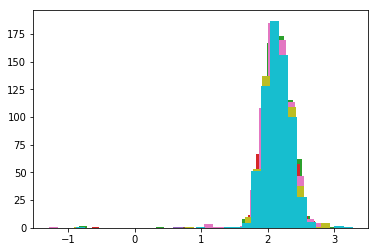

In [541]:
for i in range(10):
    plt.hist(np.log10(1000*tau_set[i][~np.isnan(tau_set[i])]), bins = 30)

Text(0.5,1,'Fit to First-Order LPF Step Response')

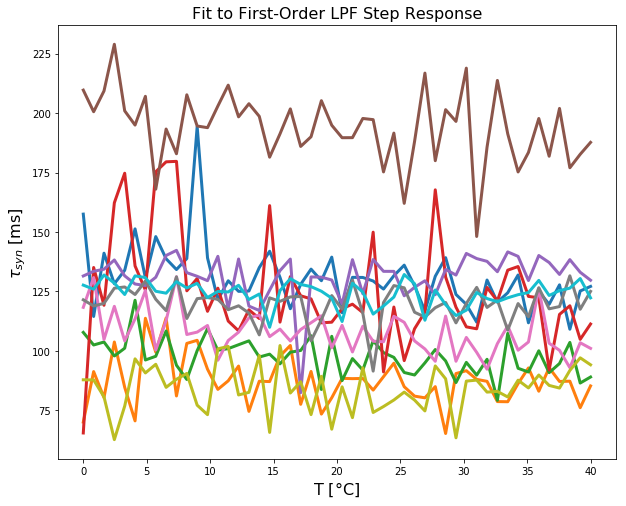

In [542]:
plt.figure(figsize = (10,8))
for i in range(10):
    plt.plot(Tarr[:r], 1000*tau_set[:,good].T[i], lw = 3)
plt.xlabel(r'T [$\degree$C]', fontsize = 16)
plt.ylabel(r'$\tau_{syn}$ [ms]', fontsize = 16)
plt.title('Fit to First-Order LPF Step Response', fontsize = 16)

In [577]:
ratio = []
taus_clean = []
tarr_clean = []
poly = []
for taus in tau_set.T:
    good = ~np.isnan(taus)
    if (np.sum(good) > 10):
        taus_clean.append(taus[good])
        tarr_clean.append(Tarr[good])
        p = np.polyfit(Tarr[good], taus[good], 1)
        ratio.append(np.abs(p[0]/p[1]))
        poly.append(p)
sort = np.argsort(ratio)
poly = np.array(poly)

-0.007083268351093031


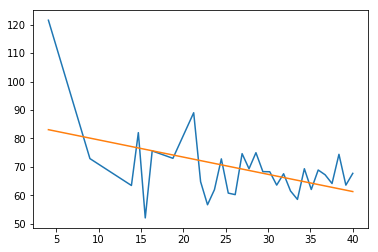

In [599]:
i = -100
p = poly[sort[i]]
print(p[0]/p[1])
tc = tarr_clean[sort[i]]
tauc = taus_clean[sort[i]]
linfit = p[0]*tc + p[1]
plt.plot(tc, 1000*tauc)
plt.plot(tc, 1000*linfit)

(0, 5)

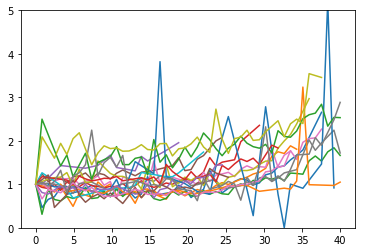

In [618]:
for i in range(1, 20):
    plt.plot(tarr_clean[sort[-i]], taus_clean[sort[-i]]/taus_clean[sort[-i]][-1], '-')
plt.ylim([0, 5])

(array([  1.,   1.,   1.,   2.,   7.,  29.,  80., 331., 254.,  22.]),
 array([-14.4360455 , -13.30330939, -12.17057328, -11.03783717,
         -9.90510106,  -8.77236495,  -7.63962884,  -6.50689273,
         -5.37415661,  -4.2414205 ,  -3.10868439]),
 <a list of 10 Patch objects>)

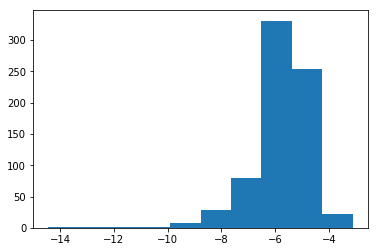

In [597]:
plt.hist(np.log(ratio))

In [461]:
def synapse_imp_response(t, tau_s, tau_p, eps):
    case1 = (t-eps) >= 0
    case2 = ((t-eps) < 0) & (t >= 0)
    
    resp1 = 1/(tau_s - tau_p)*(tau_s*np.exp(-t/tau_s)*(np.exp(eps/tau_s) - 1) - tau_p * np.exp(-t/tau_p)*(np.exp(-eps/tau_p)-1))
    resp2 = 1/(tau_s - tau_p)*(-tau_s * (np.exp(-t/tau_s) -1) + tau_p * (np.exp(-t/tau_p) - 1))
    resp = np.zeros_like(t)
    resp[case1] = resp1[case1]
    resp[case2] = resp2[case2]
    
    return resp

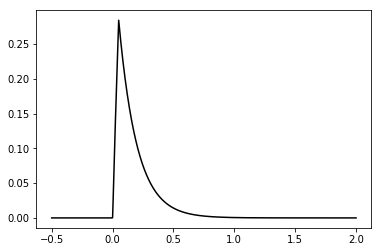

In [469]:
t = np.linspace(-0.5, 2, 1000)
tau_s = 0.15
tau_p = 0.001
eps = 0.05
resp = synapse_imp_response(t, tau_s, tau_p, eps)

plt.plot(t, resp, 'k')

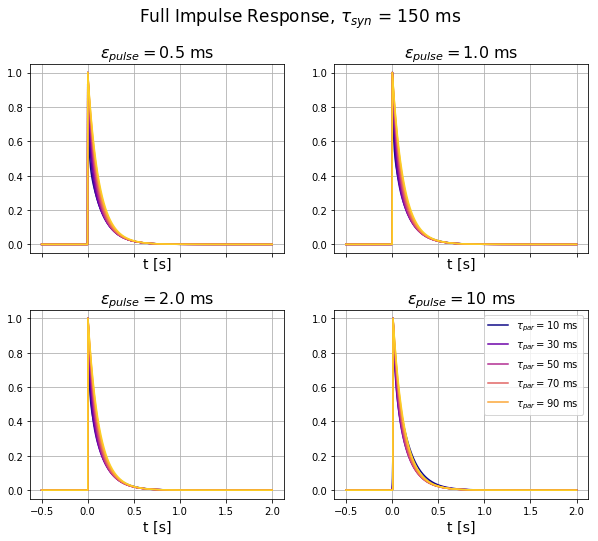

In [470]:
fig, ax = plt.subplots(2, 2, figsize = (10,8), sharex = True)
axx = ax.flatten()
tau_s = 0.15
eps_table = [0.0005, 0.001, 0.002, 0.01]
tau_ps = np.linspace(0.01, 0.1, 10)
k = 0
for ax_i, eps in zip(axx, eps_table):
    for i, tau_p in enumerate(tau_ps):
        resp = synapse_imp_response(t, tau_s, tau_p, eps)
        resp = resp/np.max(resp)
        if (k == 3):
            if(i%2 == 0):
                ax_i.plot(t, resp, c = cm.plasma(i/10), label = r'$\tau_{par} = ' + str(tau_p*1000)[:3] + '$ ms')
            else:
                ax_i.plot(t, resp, c = cm.plasma(i/10))
        else:
            ax_i.plot(t, resp, c = cm.plasma(i/10))
    ax_i.set_xlabel('t [s]', fontsize = 14)
    ax_i.set_title(r'$\epsilon_{pulse} = ' + str(eps*1000)[:3] + '$ ms', fontsize = 16)
    ax_i.grid(True)
    if(k == 3):
        ax_i.legend()
    k += 1
plt.subplots_adjust(hspace = 0.3)
plt.suptitle(r'Full Impulse Response, $\tau_{syn}$ = 150 ms', fontsize = 17)
plt.savefig('Impulse Response', dpi = 500)

In [514]:
def synapse_step_response(t, tau_s, tau_p, eps):
    t1 = np.min([t, [eps]*len(t)], axis = 0)
    resp1 = 1/(tau_s - tau_p)*(tau_s**2 * (np.exp(-t1/tau_s) -1) - tau_p**2 * (np.exp(-t1/tau_p) - 1) + (tau_s - tau_p)*t1)
    resp2 = 1/(tau_s - tau_p)*(  tau_s**2 * (np.exp(-eps/tau_s) - np.exp(-t/tau_s))*(np.exp(eps/tau_s) - 1) - \
                              tau_p**2 * (np.exp(-eps/tau_p) - np.exp(-t/tau_p))*(np.exp(eps/tau_p) - 1)  )
    case1 = (t-eps) > 0
    case2 = t > eps
    resp = np.zeros_like(t)
    resp[case1] += resp1[case1]
    resp[case2] += resp2[case2]
    return resp

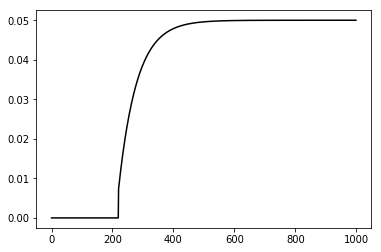

In [515]:
t = np.linspace(-0.5, 2, 1000)
tau_s = 0.15
tau_p = 0.001
eps = 0.05
resp = synapse_step_response(t, tau_s, tau_p, eps)

plt.plot(t, resp, 'k')

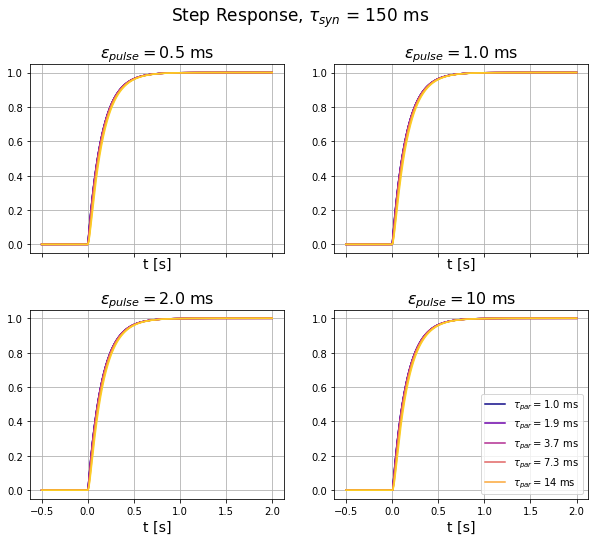

In [527]:
fig, ax = plt.subplots(2, 2, figsize = (10,8), sharex = True)
axx = ax.flatten()
tau_s = 0.15
eps_table = [0.0005, 0.001, 0.002, 0.01]
tau_ps = np.exp(np.linspace(np.log(0.001), np.log(0.02), 10))
k = 0
for ax_i, eps in zip(axx, eps_table):
    for i, tau_p in enumerate(tau_ps):
        resp = synapse_step_response(t, tau_s, tau_p, eps)
        resp = resp/np.max(resp)
        if (k == 3):
            if(i%2 == 0):
                ax_i.plot(t, resp, c = cm.plasma(i/10), label = r'$\tau_{par} = ' + str(tau_p*1000)[:3] + '$ ms')
            else:
                ax_i.plot(t, resp, c = cm.plasma(i/10))
        else:
            ax_i.plot(t, resp, c = cm.plasma(i/10))
    ax_i.set_xlabel('t [s]', fontsize = 14)
    ax_i.set_title(r'$\epsilon_{pulse} = ' + str(eps*1000)[:3] + '$ ms', fontsize = 16)
    ax_i.grid(True)
    if(k == 3):
        ax_i.legend()
    k += 1
plt.subplots_adjust(hspace = 0.3)
plt.suptitle(r'Step Response, $\tau_{syn}$ = 150 ms', fontsize = 17)
plt.savefig('Step Response', dpi = 500)